In [6]:
# import useful packages

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import seaborn as sns
sns.set()

mpl.rcParams['lines.linewidth']=2.0
mpl.rcParams['xtick.labelsize']=13
mpl.rcParams['ytick.labelsize']=13
mpl.rcParams['axes.labelsize']=15
mpl.rcParams['axes.labelweight']='heavy'
mpl.rcParams['axes.titlesize']=18
mpl.rcParams['axes.titleweight']='heavy'
mpl.rcParams['legend.fontsize']=12



from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score

import category_encoders as ce

import os
import sys

In [7]:
src_dir = os.path.join(os.path.dirname(os.getcwd()),'adfraud')
sys.path.append(src_dir)

data_dir = os.path.join(os.path.dirname(os.getcwd()),'data')

data_filename = 'train_sample.csv'
data_location = os.path.join(data_dir,data_filename)
ad_data = pd.read_csv(data_location)
feats_df  = ad_data[['ip','app','channel']]
labels_df = ad_data['is_attributed'].values
#labels = ad_data['is_attributed'].values

In [8]:


x_train,x_test,y_train,y_test = train_test_split(feats_df,labels_df,test_size=0.3)

#### Encode the Channel and App fields ####

In [9]:
hasher = ce.hashing.HashingEncoder(n_components=50,cols=['app','channel'])

Here, I've used a hashing encoder, hashing the categorical fields into a smaller number of columns than would be found with a one hot encoder.

We can treat the number of components as a hyperparameter of the model.

In [10]:
hasher.fit(x_train)

HashingEncoder(cols=['app', 'channel'], drop_invariant=False, hash_method='md5',
               n_components=50, return_df=True, verbose=0)

In [11]:
x_train_hashed = hasher.transform(x_train)

In [12]:
x_train_hashed.head(5)

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_41,col_42,col_43,col_44,col_45,col_46,col_47,col_48,col_49,ip
85160,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,175837
9165,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,577
81516,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,71035
74369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,65729
76748,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,39453


Note that I have not hashed ip, juts the app and channel fields.

Some **issues** to have in mind for this model:

 - out-of-sample test data. If we have app and channel fields in the test set that do not appear in the training set, this will obviously cuase problems.
 
 - ip is categorical really. In a real-time system - would want to classify based on times seen in previous x minutes/hours or something maybe. Since we will| use random forest classification, leaving ip in it's raw format may be acceptable for this problem. 

In [13]:
clf = RandomForestClassifier(n_estimators=20, max_depth=5,class_weight={0:0.001,1:0.999})

In [14]:
clf.fit(x_train_hashed.values,y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 0.001, 1: 0.999},
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=20, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [15]:
print(np.shape(x_train_hashed.values))
print(np.shape(y_train))

(70000, 51)
(70000,)


In [16]:
x_test_hashed = hasher.transform(x_test)
preds = clf.predict_proba(x_test_hashed.values)

In [17]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, preds[:,1])
auc = metrics.roc_auc_score(y_test, preds[:,1])
print(auc)

0.9543309581273384


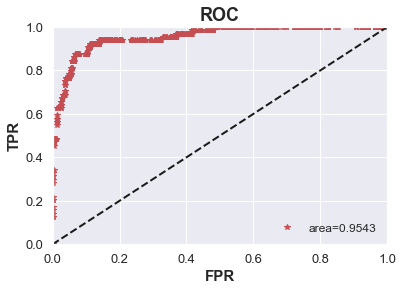

In [18]:
plt.plot(fpr,tpr,'r*', label='area={:.4f}'.format(auc))
plt.plot(np.linspace(0,1,20),np.linspace(0,1,20),'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')

plt.legend(frameon=False)

plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.show()

Let's confirm what happens when the hasher recieves a set of features that don't appear in the training:

In [19]:
atest = x_train.head(1).copy().reset_index()
atest = atest.drop(['index'],axis=1)

In [20]:
atest

,ip,app,channel
0,175837,20,259


reset the elements of the simple checking data sample to out-of-sample values

In [21]:
atest.loc[0,'ip']     =1234567
atest.loc[0,'app']    =1234567
atest.loc[0,'channel']=1234567

In [22]:
atest

,ip,app,channel
0,1234567,1234567,1234567


In [23]:
hasher.transform(atest)

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_41,col_42,col_43,col_44,col_45,col_46,col_47,col_48,col_49,ip
0,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,1234567


So, it will  hash to something the random forest can classify.

In [24]:
clf.predict_proba(hasher.transform(atest))

array([[0.28261006, 0.71738994]])

How does the accuracy of the model vary with the threshold?

In [27]:
def pred_from_prob(a,thrshld):
    bin_preds = np.zeros((np.size(a,0),))
    bin_preds[np.where(a[:,1]>thrshld)]=1.0
    return bin_preds

In [39]:
binary_preds = pred_from_prob(preds,0.61)
print(accuracy_score(y_test,binary_preds))
print(accuracy_score(y_test[np.where(y_test==1)],binary_preds[np.where(y_test==1)]))
print(accuracy_score(y_test[np.where(y_test==0)],binary_preds[np.where(y_test==0)]))



0.8963
0.875
0.8963455371459113


In [40]:
#thrshs = np.linspace(0.01, 1.0, 50)
acc_tot = []
acc_0 = []
acc_1 = []
for ind,th in enumerate(thresholds):
    binary_preds = pred_from_prob(preds,th)
    acc_tot.append(accuracy_score(y_test,binary_preds))
    acc_1.append(accuracy_score(y_test[np.where(y_test==1)],binary_preds[np.where(y_test==1)]))
    acc_0.append(accuracy_score(y_test[np.where(y_test==0)],binary_preds[np.where(y_test==0)]))



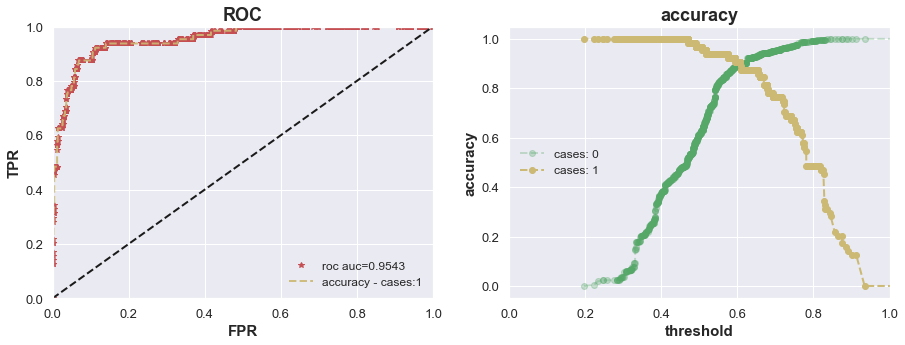

In [64]:
mpl.rcParams['figure.figsize']=[15.0,5.0]

plt.subplot(1,2,1)
plt.plot(fpr,tpr,'r*', label='roc auc={:.4f}'.format(auc))
plt.plot(np.linspace(0,1,20),np.linspace(0,1,20),'k--')

#plt.plot(fpr,acc_tot,'b*-',label='accuracy')
#plt.plot(fpr,acc_0,'go--',label='accuracy - 0',alpha=0.3)
plt.plot(fpr,acc_1,'y--',alpha=0.9,label='accuracy - cases:1')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')

plt.legend(frameon=False)

plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])


plt.subplot(1,2,2)

#plt.plot(thresholds,acc_tot,'b*-',label='accuracy')
plt.plot(thresholds,acc_0,'go--',label='cases: 0',alpha=0.3)
plt.plot(thresholds,acc_1,'yo--',label='cases: 1')

plt.xlim([0,1])
plt.xlim([0,1])

plt.xlabel('threshold')
plt.ylabel('accuracy')
plt.title('accuracy')

plt.legend(frameon=False)

plt.show()